## Diagonal integration with contrastive learning

A integration task is called diagonal integration if different modalities share no correspondence information, either among cells or features, e.g., scATAC peaks and scRNA genes, we can use label annotations as prior information to improve the performance.

In [1]:
import uniport as up
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
up.__version__

'1.1.1'

Load PBMC scATAC peaks and scRNA counts.

In [2]:
adata_peaks = sc.read_h5ad('PBMC/atac_peaks.h5ad')
# adata_peaks = up.load_file('PBMC/pbmc_signac_peaks.tsv.gz')
adata_rna = up.load_file('PBMC/RNA_count.txt')

In [3]:
labels = pd.read_csv('PBMC/meta.txt', sep='\t')
celltype = labels['cluster'].values

In [4]:
adata_peaks.obs['cell_type'] = celltype
adata_peaks.obs['domain_id'] = 0
adata_peaks.obs['domain_id'] = adata_peaks.obs['domain_id'].astype('category')
adata_peaks.obs['source'] = 'ATAC-peaks'

adata_rna.obs['cell_type'] = celltype
adata_rna.obs['domain_id'] = 1
adata_rna.obs['domain_id'] = adata_rna.obs['domain_id'].astype('category')
adata_rna.obs['source'] = 'RNA'

print(adata_rna.obs)
print(adata_peaks.obs)

                    cell_type domain_id source
AAACAGCCAAGGAATC.1  CD4 Naive         1    RNA
AAACAGCCAATCCCTT.1   CD4 Tmem         1    RNA
AAACAGCCAATGCGCT.1  CD4 Naive         1    RNA
AAACAGCCACACTAAT.1  CD8 Naive         1    RNA
AAACAGCCACCAACCG.1  CD8 Naive         1    RNA
...                       ...       ...    ...
TTTGTTGGTGACATGC.1  CD8 Naive         1    RNA
TTTGTTGGTGTTAAAC.1  CD8 Naive         1    RNA
TTTGTTGGTTAGGATT.1         NK         1    RNA
TTTGTTGGTTGGTTAG.1   CD4 Tmem         1    RNA
TTTGTTGGTTTGCAGA.1   CD8 Tmem         1    RNA

[11259 rows x 3 columns]
                    cell_type domain_id      source
AAACAGCCAAGGAATC-1  CD4 Naive         0  ATAC-peaks
AAACAGCCAATCCCTT-1   CD4 Tmem         0  ATAC-peaks
AAACAGCCAATGCGCT-1  CD4 Naive         0  ATAC-peaks
AAACAGCCACACTAAT-1  CD8 Naive         0  ATAC-peaks
AAACAGCCACCAACCG-1  CD8 Naive         0  ATAC-peaks
...                       ...       ...         ...
TTTGTTGGTGACATGC-1  CD8 Naive         0  ATAC-

Preprocess scATAC peaks using `up.TFIDF_LSI`.

In [5]:
adata_peaks.X[adata_peaks.X>1] = 1
sc.pp.normalize_total(adata_peaks)
up.TFIDF_LSI(adata_peaks)
scaler = MinMaxScaler()
adata_peaks.obsm['X_lsi'] = scaler.fit_transform(adata_peaks.obsm['X_lsi'])

In [6]:
sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(adata_rna)

Diagonal integration without prior information.

In [7]:
adata1 = up.Run(adatas=[adata_peaks, adata_rna], use_rep=['X_lsi','X'], mode='d')

Dataset 0: ATAC-peaks
AnnData object with n_obs × n_vars = 11259 × 131364
    obs: 'cell_type', 'domain_id', 'source'
    obsm: 'X_lsi'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1




Epochs: 100%|██████████████████████████| 345/345 [15:29<00:00,  2.69s/it, recon_loss=1505.593,kl_loss=8.341,ot_loss=4.676]


Construct prior correspondence information with label annotation.

In [8]:
alpha=2
prior = up.get_prior(adata_peaks.obs['cell_type'].values, adata_rna.obs['cell_type'].values, alpha=alpha)

Diagonal integration with correspondence information.

In [9]:
adata2 = up.Run(adatas=[adata_peaks, adata_rna], use_rep=['X_lsi','X'], prior=[prior], mode='d', lambda_ot=5)

Dataset 0: ATAC-peaks
AnnData object with n_obs × n_vars = 11259 × 131364
    obs: 'cell_type', 'domain_id', 'source'
    obsm: 'X_lsi', 'latent'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 11259 × 2000
    obs: 'cell_type', 'domain_id', 'source'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'latent'
Reference dataset is dataset 1




Epochs: 100%|█████████████████████████| 345/345 [15:59<00:00,  2.78s/it, recon_loss=1510.078,kl_loss=6.985,ot_loss=19.150]


UMAP visualization of scATAC peaks.

... storing 'cell_type' as categorical
... storing 'source' as categorical


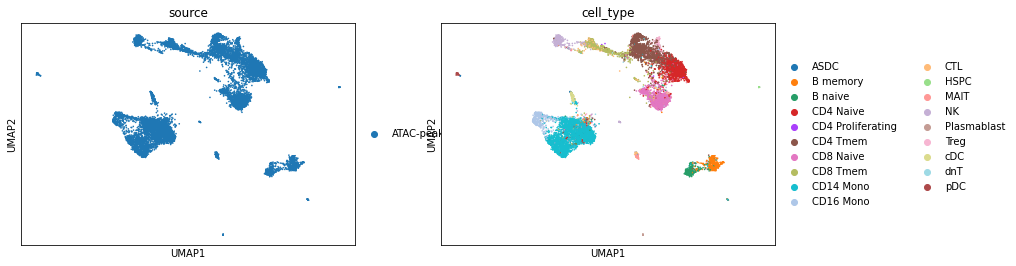

In [10]:
sc.pp.neighbors(adata_peaks, use_rep='X_lsi')
sc.tl.umap(adata_peaks, min_dist=0.1)
sc.pl.umap(adata_peaks, color=['source', 'cell_type'])

UMAP visualization of scRNA genes.

... storing 'cell_type' as categorical
... storing 'source' as categorical


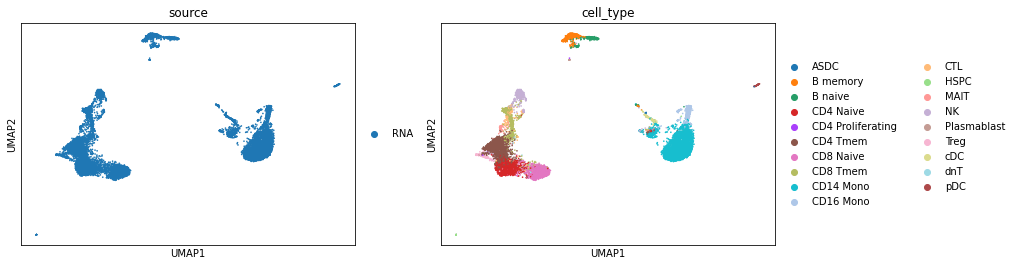

In [11]:
sc.pp.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna, min_dist=0.1)
sc.pl.umap(adata_rna, color=['source', 'cell_type'])

UMAP visualization after uniPort diagonal integration.

... storing 'cell_type' as categorical
... storing 'source' as categorical


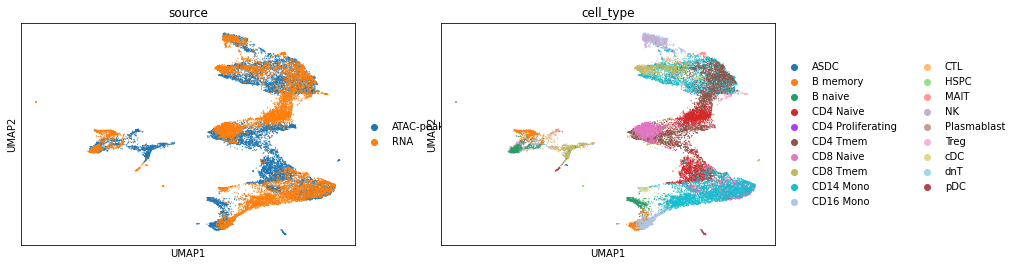

In [12]:
sc.pp.neighbors(adata1, use_rep='latent')
sc.tl.umap(adata1, min_dist=0.1)
sc.pl.umap(adata1, color=['source', 'cell_type'])

UMAP visualization after uniPort diagonal integration with **contrastive learning**.

... storing 'cell_type' as categorical
... storing 'source' as categorical


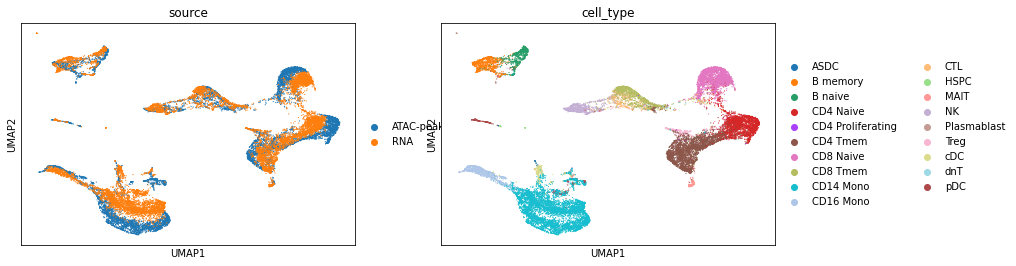

In [13]:
sc.pp.neighbors(adata2, use_rep='latent')
sc.tl.umap(adata2, min_dist=0.1)
sc.pl.umap(adata2, color=['source', 'cell_type'])